<a href="https://colab.research.google.com/github/badhan7700/Traffic-Sign-Recognition-Web-App/blob/main/TrafficSignRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GTSRB Traffic Sign Classification
**Simple CNN + MobileNetV2 Transfer Learning**

This notebook trains two models:
1. Simple CNN (from scratch)
2. MobileNetV2 (transfer learning)

---

## Part 1: Setup & Data Loading

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Imports
import os
import pickle
import random
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f'TensorFlow: {tf.__version__}')

TensorFlow: 2.19.0


In [3]:
# Load Dataset
BASE_PATH = '/content/drive/MyDrive/TrafficSignProject/GTSRB'

def load_data(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return np.array(data['features']), np.array(data['labels'])

X_train, y_train = load_data(f'{BASE_PATH}/train.p')
X_valid, y_valid = load_data(f'{BASE_PATH}/valid.p')
X_test, y_test = load_data(f'{BASE_PATH}/test.p')

# Load class names
df_signs = pd.read_csv(f'{BASE_PATH}/signname.csv')
NUM_CLASSES = len(df_signs)
sign_names = dict(zip(df_signs.ClassId, df_signs.SignName))

print(f'Classes: {NUM_CLASSES}')
print(f'Train: {X_train.shape}, Valid: {X_valid.shape}, Test: {X_test.shape}')

Classes: 43
Train: (34799, 32, 32, 3), Valid: (4410, 32, 32, 3), Test: (12630, 32, 32, 3)


In [4]:
# Preprocessing - Normalize to [0, 1]
X_train = X_train.astype('float32') / 255.0
X_valid = X_valid.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# One-hot encode labels
y_train_oh = to_categorical(y_train, NUM_CLASSES)
y_valid_oh = to_categorical(y_valid, NUM_CLASSES)
y_test_oh = to_categorical(y_test, NUM_CLASSES)

print(f'Data range: [{X_train.min():.1f}, {X_train.max():.1f}]')

Data range: [0.0, 1.0]


## Part 2: Data Visualization

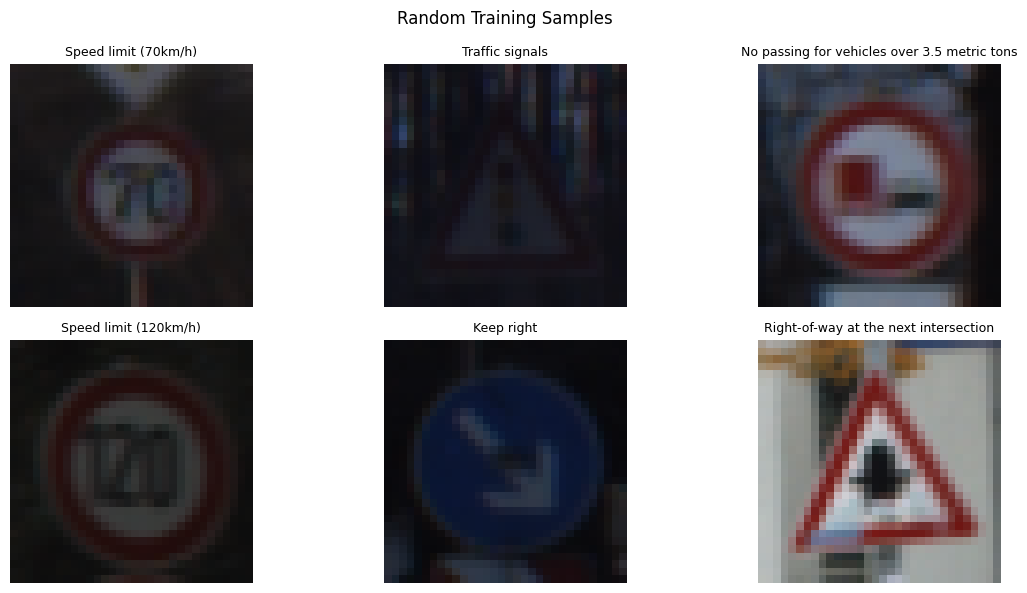

In [5]:
# Show random samples
plt.figure(figsize=(12, 6))
for i in range(6):
    idx = random.randint(0, len(X_train)-1)
    plt.subplot(2, 3, i+1)
    plt.imshow(X_train[idx])
    plt.title(sign_names[y_train[idx]], fontsize=9)
    plt.axis('off')
plt.suptitle('Random Training Samples')
plt.tight_layout()
plt.show()

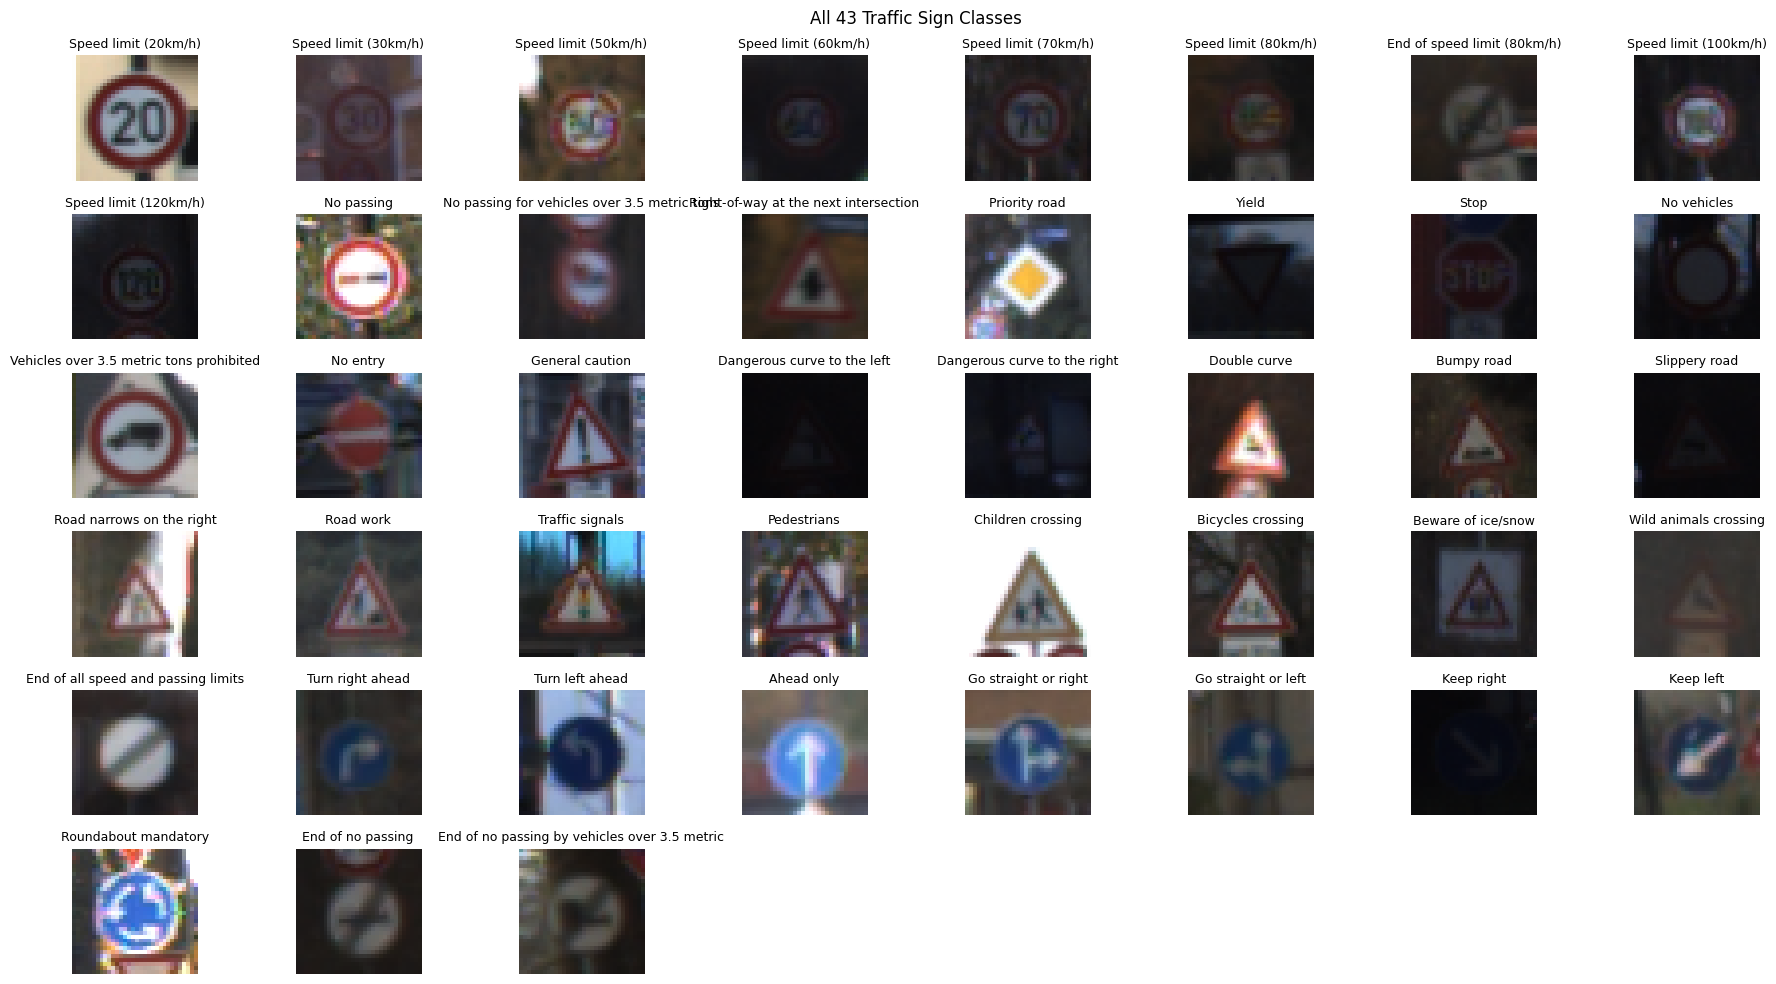

In [6]:
# Show one sample per class
examples = {}
for i, label in enumerate(y_train):
    if label not in examples:
        examples[label] = i
    if len(examples) == NUM_CLASSES:
        break

plt.figure(figsize=(18, 10))
for i, (label, idx) in enumerate(sorted(examples.items())):
    plt.subplot(6, 8, i+1)
    plt.imshow(X_train[idx])
    plt.title(sign_names[y_train[idx]], fontsize=9)
    plt.axis('off')
plt.suptitle('All 43 Traffic Sign Classes')
plt.tight_layout()
plt.show()

---
## Part 3: Model 1 - Simple CNN

In [7]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

BATCH_SIZE = 32
train_gen = train_datagen.flow(X_train, y_train_oh, batch_size=BATCH_SIZE, shuffle=True)
valid_gen = ImageDataGenerator().flow(X_valid, y_valid_oh, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
# Build Simple CNN
simple_cnn = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

simple_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
simple_cnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 276,043 (1.05 MB)

 Trainable params: 276,043 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train Simple CNN
cnn_ckpt = '/content/drive/MyDrive/TrafficSignProject/simple_cnn_best.h5'

cnn_callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ModelCheckpoint(cnn_ckpt, monitor='val_accuracy', save_best_only=True)
]

history_cnn = simple_cnn.fit(
    train_gen,
    epochs=15,
    validation_data=valid_gen,
    callbacks=cnn_callbacks
)

# Evaluate
cnn_loss, cnn_acc = simple_cnn.evaluate(X_test, y_test_oh, verbose=0)
print(f'\nSimple CNN Test Accuracy: {cnn_acc*100:.2f}%')

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1087/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2300 - loss: 2.8345

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - accuracy: 0.2303 - loss: 2.8331 - val_accuracy: 0.7707 - val_loss: 0.7807
Epoch 2/15
1087/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6956 - loss: 0.9496

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6957 - loss: 0.9493 - val_accuracy: 0.9070 - val_loss: 0.3340
Epoch 3/15
1087/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8491 - loss: 0.4619

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.8492 - loss: 0.4618 - val_accuracy: 0.9533 - val_loss: 0.2517
Epoch 4/15
1087/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9068 - loss: 0.3003

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.9068 - loss: 0.3003 - val_accuracy: 0.9617 - val_loss: 0.1949
Epoch 5/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9296 - loss: 0.2181

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.9297 - loss: 0.2181 - val_accuracy: 0.9762 - val_loss: 0.1064
Epoch 6/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9466 - loss: 0.1729

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.9466 - loss: 0.1729 - val_accuracy: 0.9794 - val_loss: 0.1110
Epoch 7/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.9570 - loss: 0.1412 - val_accuracy: 0.9769 - val_loss: 0.1079
Epoch 8/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.9609 - loss: 0.1226 - val_accuracy: 0.9782 - val_loss: 0.0929
Epoch 9/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9673 - loss: 0.1079

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.9673 - loss: 0.1079 - val_accuracy: 0.9819 - val_loss: 0.0743
Epoch 10/15
1086/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9716 - loss: 0.0928

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.9716 - loss: 0.0928 - val_accuracy: 0.9832 - val_loss: 0.0618
Epoch 11/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.9763 - loss: 0.0834 - val_accuracy: 0.9805 - val_loss: 0.0719
Epoch 12/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - accuracy: 0.9751 - loss: 0.0789 - val_accuracy: 0.9828 - val_loss: 0.0878
Epoch 13/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9791 - loss: 0.0741

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.9791 - loss: 0.0741 - val_accuracy: 0.9844 - val_loss: 0.0510
Epoch 14/15
1086/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9803 - loss: 0.0659

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.9803 - loss: 0.0659 - val_accuracy: 0.9864 - val_loss: 0.0472
Epoch 15/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.9809 - loss: 0.0632 - val_accuracy: 0.9864 - val_loss: 0.0479

Simple CNN Test Accuracy: 97.49%


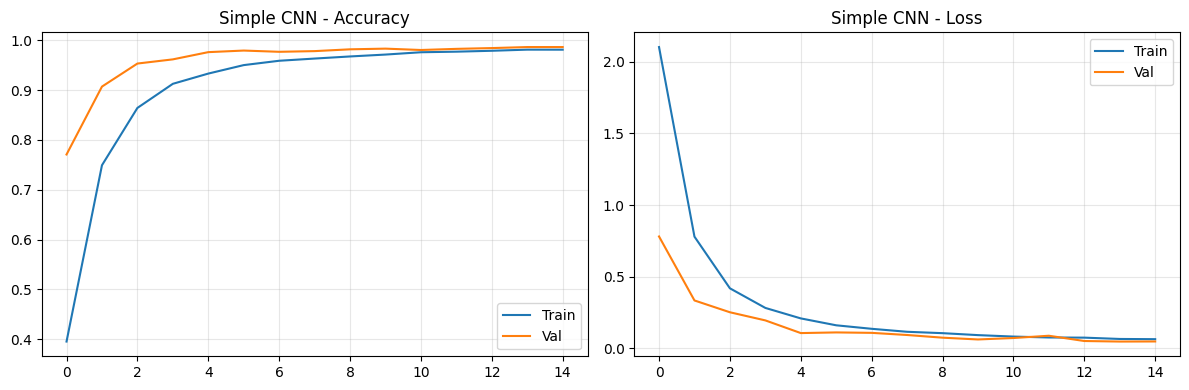

In [10]:
# Plot CNN Training
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(history_cnn.history['accuracy'], label='Train')
ax[0].plot(history_cnn.history['val_accuracy'], label='Val')
ax[0].set_title('Simple CNN - Accuracy')
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].plot(history_cnn.history['loss'], label='Train')
ax[1].plot(history_cnn.history['val_loss'], label='Val')
ax[1].set_title('Simple CNN - Loss')
ax[1].legend()
ax[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()

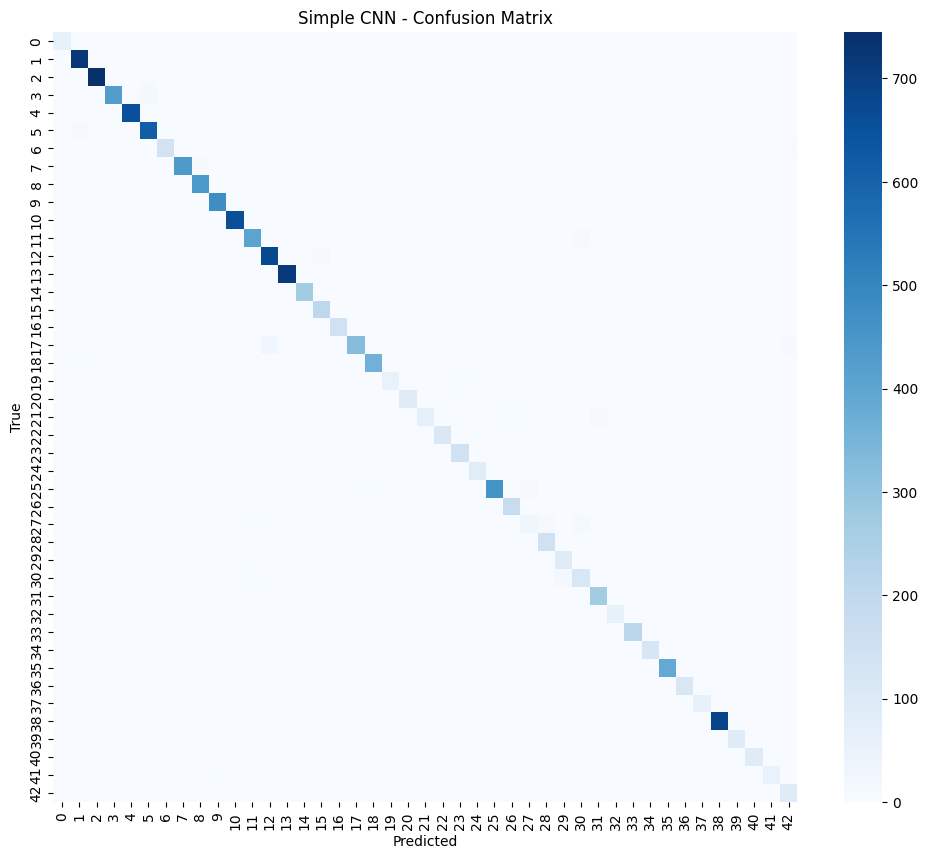

              precision    recall  f1-score   support

           0      0.968     1.000     0.984        60
           1      0.972     0.999     0.985       720
           2      0.995     0.993     0.994       750
           3      0.986     0.956     0.971       450
           4      0.991     0.989     0.990       660
           5      0.956     0.976     0.966       630
           6      0.993     0.920     0.955       150
           7      0.995     0.973     0.984       450
           8      0.974     0.987     0.980       450
           9      0.981     0.994     0.988       480
          10      0.997     0.998     0.998       660
          11      0.947     0.969     0.958       420
          12      0.960     0.981     0.971       690
          13      0.999     0.996     0.997       720
          14      1.000     1.000     1.000       270
          15      0.954     0.995     0.974       210
          16      0.993     1.000     0.997       150
          17      1.000    

In [11]:
# CNN Confusion Matrix
y_pred_cnn = np.argmax(simple_cnn.predict(X_test, verbose=0), axis=1)

plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix(y_test, y_pred_cnn), cmap='Blues', annot=False)
plt.title('Simple CNN - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_test, y_pred_cnn, digits=3))

---
## Part 4: Model 2 - MobileNetV2 (Transfer Learning)

In [12]:
# Resize images for MobileNetV2 (needs larger input)
IMG_SIZE = 96

def resize_images(X, size):
    resized = np.zeros((len(X), size, size, 3), dtype=np.float32)
    for i in range(len(X)):
        resized[i] = cv2.resize(X[i], (size, size))
    return resized

X_train_m = resize_images(X_train, IMG_SIZE)
X_valid_m = resize_images(X_valid, IMG_SIZE)
X_test_m = resize_images(X_test, IMG_SIZE)

print(f'Resized: {X_train_m.shape}')

Resized: (34799, 96, 96, 3)


In [13]:
# Build MobileNetV2 Model (lightweight version)
# NOTE: Using Rescaling layer instead of Lambda for better model serialization
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    alpha=0.35  # Smallest variant
)
base_model.trainable = False  # Freeze base

# Build model WITHOUT Lambda layers (for better serialization)
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
# Rescaling: converts [0,1] to [-1,1] (MobileNetV2 expected range)
x = layers.Rescaling(scale=2.0, offset=-1.0)(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

mobile_model = models.Model(inputs, outputs)
mobile_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
mobile_model.summary()

2019640/2019640 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_0.35_96             │ (None, 3, 3, 1280)     │       410,208 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 749,195 (2.86 MB)

 Trainable params: 338,987 (1.29 MB)

 Non-trainable params: 410,208 (1.56 MB)

In [14]:
# Data generators for MobileNet
train_datagen_m = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.08,
    height_shift_range=0.08,
    zoom_range=0.08
)

train_gen_m = train_datagen_m.flow(X_train_m, y_train_oh, batch_size=BATCH_SIZE, shuffle=True)
valid_gen_m = ImageDataGenerator().flow(X_valid_m, y_valid_oh, batch_size=BATCH_SIZE, shuffle=False)

In [15]:
# Train MobileNetV2 (frozen base)
mobile_ckpt = '/content/drive/MyDrive/TrafficSignProject/mobilenetv2_best.h5'

mobile_callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True),
    ModelCheckpoint(mobile_ckpt, monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

history_mobile = mobile_model.fit(
    train_gen_m,
    epochs=10,
    validation_data=valid_gen_m,
    callbacks=mobile_callbacks
)

# Evaluate
mobile_loss, mobile_acc = mobile_model.evaluate(X_test_m, y_test_oh, verbose=0)
print(f'\nMobileNetV2 Test Accuracy: {mobile_acc*100:.2f}%')

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.4620 - loss: 1.8562

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 139s 112ms/step - accuracy: 0.4621 - loss: 1.8557 - val_accuracy: 0.6091 - val_loss: 1.1946 - learning_rate: 0.0010
Epoch 2/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.6909 - loss: 0.9134

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 99s 91ms/step - accuracy: 0.6909 - loss: 0.9134 - val_accuracy: 0.6313 - val_loss: 1.1959 - learning_rate: 0.0010
Epoch 3/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 97s 89ms/step - accuracy: 0.7346 - loss: 0.7842 - val_accuracy: 0.6252 - val_loss: 1.2655 - learning_rate: 0.0010
Epoch 4/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7792 - loss: 0.6410

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 99s 91ms/step - accuracy: 0.7792 - loss: 0.6410 - val_accuracy: 0.6615 - val_loss: 1.1714 - learning_rate: 5.0000e-04
Epoch 5/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 97s 89ms/step - accuracy: 0.7985 - loss: 0.5918 - val_accuracy: 0.6526 - val_loss: 1.1356 - learning_rate: 5.0000e-04
Epoch 6/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 100s 92ms/step - accuracy: 0.8077 - loss: 0.5612 - val_accuracy: 0.6494 - val_loss: 1.2183 - learning_rate: 5.0000e-04
Epoch 7/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 96s 88ms/step - accuracy: 0.8120 - loss: 0.5379 - val_accuracy: 0.6596 - val_loss: 1.1715 - learning_rate: 5.0000e-04
Epoch 8/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8260 - loss: 0.4932

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 98s 90ms/step - accuracy: 0.8260 - loss: 0.4932 - val_accuracy: 0.6689 - val_loss: 1.1804 - learning_rate: 2.5000e-04
Epoch 9/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8359 - loss: 0.4746

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 100s 92ms/step - accuracy: 0.8359 - loss: 0.4746 - val_accuracy: 0.6728 - val_loss: 1.1619 - learning_rate: 2.5000e-04
Epoch 10/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8422 - loss: 0.4535

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 98s 90ms/step - accuracy: 0.8422 - loss: 0.4535 - val_accuracy: 0.6737 - val_loss: 1.1781 - learning_rate: 1.2500e-04

MobileNetV2 Test Accuracy: 71.48%


In [16]:
# OPTIONAL: Fine-tune MobileNetV2
# Set to True if you want better accuracy (takes longer)
FINE_TUNE = True

if FINE_TUNE:
    print('Fine-tuning last 30 layers...')
    base_model.trainable = True
    for layer in base_model.layers[:-30]:
        layer.trainable = False

    mobile_model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history_ft = mobile_model.fit(
        train_gen_m,
        epochs=8,
        validation_data=valid_gen_m,
        callbacks=mobile_callbacks
    )

    mobile_loss, mobile_acc = mobile_model.evaluate(X_test_m, y_test_oh, verbose=0)
    print(f'Fine-tuned Accuracy: {mobile_acc*100:.2f}%')
else:
    print('Fine-tuning skipped (set FINE_TUNE=True to enable)')

Fine-tuning last 30 layers...
Epoch 1/8
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 134s 106ms/step - accuracy: 0.6589 - loss: 1.4344 - val_accuracy: 0.6637 - val_loss: 1.3311 - learning_rate: 1.0000e-04
Epoch 2/8
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8238 - loss: 0.5249

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 100s 92ms/step - accuracy: 0.8238 - loss: 0.5248 - val_accuracy: 0.7048 - val_loss: 1.2338 - learning_rate: 1.0000e-04
Epoch 3/8
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8608 - loss: 0.3955

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 100s 92ms/step - accuracy: 0.8608 - loss: 0.3955 - val_accuracy: 0.7379 - val_loss: 1.0830 - learning_rate: 1.0000e-04
Epoch 4/8
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 99s 91ms/step - accuracy: 0.8868 - loss: 0.3277 - val_accuracy: 0.7379 - val_loss: 1.1519 - learning_rate: 1.0000e-04
Epoch 5/8
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9019 - loss: 0.2858

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 100s 92ms/step - accuracy: 0.9019 - loss: 0.2858 - val_accuracy: 0.7474 - val_loss: 1.0829 - learning_rate: 1.0000e-04
Epoch 6/8
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9153 - loss: 0.2416

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 99s 91ms/step - accuracy: 0.9153 - loss: 0.2415 - val_accuracy: 0.7714 - val_loss: 0.9320 - learning_rate: 5.0000e-05
Epoch 7/8
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9302 - loss: 0.2021

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 100s 92ms/step - accuracy: 0.9302 - loss: 0.2021 - val_accuracy: 0.7760 - val_loss: 0.9650 - learning_rate: 5.0000e-05
Epoch 8/8
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 101s 93ms/step - accuracy: 0.9323 - loss: 0.1947 - val_accuracy: 0.7737 - val_loss: 0.9523 - learning_rate: 5.0000e-05
Fine-tuned Accuracy: 79.81%


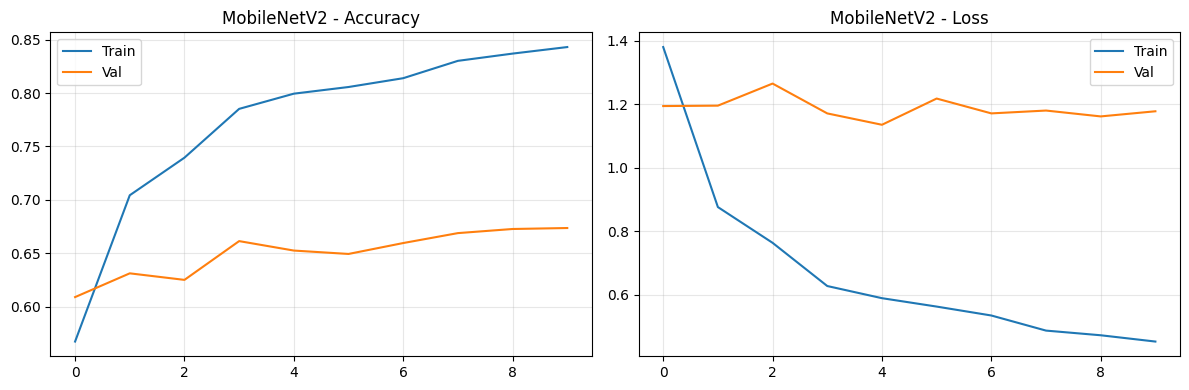

In [17]:
# Plot MobileNet Training
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(history_mobile.history['accuracy'], label='Train')
ax[0].plot(history_mobile.history['val_accuracy'], label='Val')
ax[0].set_title('MobileNetV2 - Accuracy')
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].plot(history_mobile.history['loss'], label='Train')
ax[1].plot(history_mobile.history['val_loss'], label='Val')
ax[1].set_title('MobileNetV2 - Loss')
ax[1].legend()
ax[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()

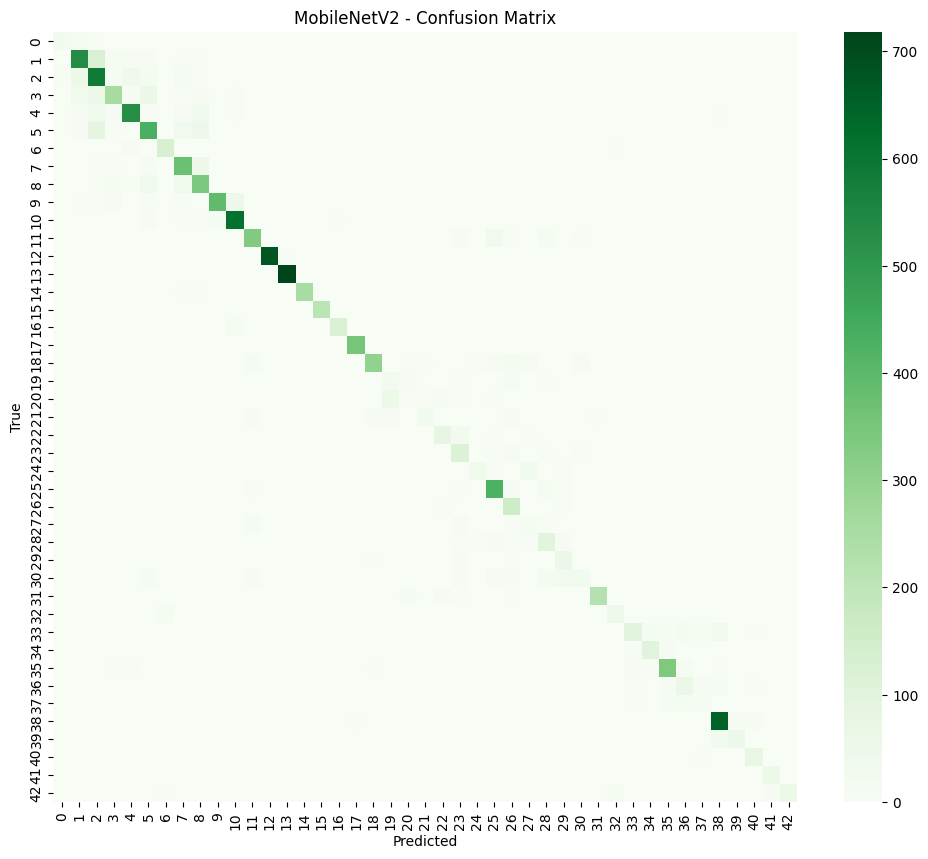

              precision    recall  f1-score   support

           0      0.829     0.483     0.611        60
           1      0.785     0.746     0.765       720
           2      0.627     0.783     0.696       750
           3      0.721     0.573     0.639       450
           4      0.848     0.800     0.823       660
           5      0.698     0.687     0.693       630
           6      0.824     0.873     0.848       150
           7      0.735     0.831     0.780       450
           8      0.665     0.758     0.708       450
           9      0.931     0.817     0.870       480
          10      0.889     0.933     0.911       660
          11      0.841     0.793     0.816       420
          12      0.996     0.986     0.991       690
          13      0.986     0.997     0.992       720
          14      0.996     0.933     0.964       270
          15      1.000     0.995     0.998       210
          16      0.970     0.853     0.908       150
          17      0.989    

In [18]:
# MobileNet Confusion Matrix
y_pred_mobile = np.argmax(mobile_model.predict(X_test_m, verbose=0), axis=1)

plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix(y_test, y_pred_mobile), cmap='Greens', annot=False)
plt.title('MobileNetV2 - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_test, y_pred_mobile, digits=3))

---
## Part 5: Model Comparison

MODEL COMPARISON
Simple CNN:   97.49% accuracy
MobileNetV2:  79.81% accuracy

Parameters:
Simple CNN:   276,043
MobileNetV2:  749,195


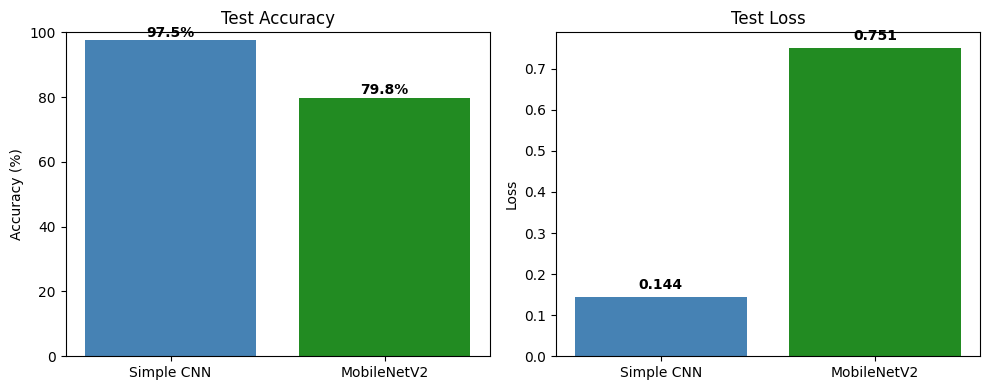


Best Model: Simple CNN


In [19]:
# Compare Models
print('='*50)
print('MODEL COMPARISON')
print('='*50)
print(f'Simple CNN:   {cnn_acc*100:.2f}% accuracy')
print(f'MobileNetV2:  {mobile_acc*100:.2f}% accuracy')
print(f'\nParameters:')
print(f'Simple CNN:   {simple_cnn.count_params():,}')
print(f'MobileNetV2:  {mobile_model.count_params():,}')

# Bar chart comparison
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
names = ['Simple CNN', 'MobileNetV2']
colors = ['steelblue', 'forestgreen']

# Accuracy
accs = [cnn_acc*100, mobile_acc*100]
bars1 = ax[0].bar(names, accs, color=colors)
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_title('Test Accuracy')
ax[0].set_ylim(0, 100)
for b, a in zip(bars1, accs):
    ax[0].text(b.get_x()+b.get_width()/2, b.get_height()+1, f'{a:.1f}%', ha='center', fontweight='bold')

# Loss
losses = [cnn_loss, mobile_loss]
bars2 = ax[1].bar(names, losses, color=colors)
ax[1].set_ylabel('Loss')
ax[1].set_title('Test Loss')
for b, l in zip(bars2, losses):
    ax[1].text(b.get_x()+b.get_width()/2, b.get_height()+0.02, f'{l:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

best = 'Simple CNN' if cnn_acc > mobile_acc else 'MobileNetV2'
print(f'\nBest Model: {best}')

---
## Part 6: Test with Custom Image

Upload a traffic sign image:


Saving Screenshot 2025-12-09 024124.png to Screenshot 2025-12-09 024124.png


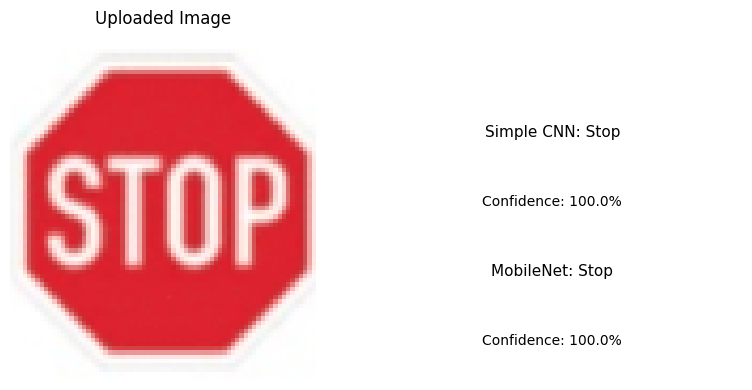

In [20]:
# Upload and predict custom image
from google.colab import files

print('Upload a traffic sign image:')
uploaded = files.upload()

for filename in uploaded.keys():
    img = Image.open(filename).convert('RGB')

    # Simple CNN prediction (32x32)
    img_cnn = np.array(img.resize((32, 32))).astype('float32') / 255.0
    pred_cnn = simple_cnn.predict(img_cnn.reshape(1, 32, 32, 3), verbose=0)
    cls_cnn = np.argmax(pred_cnn)

    # MobileNet prediction (96x96)
    img_mob = np.array(img.resize((IMG_SIZE, IMG_SIZE))).astype('float32') / 255.0
    pred_mob = mobile_model.predict(img_mob.reshape(1, IMG_SIZE, IMG_SIZE, 3), verbose=0)
    cls_mob = np.argmax(pred_mob)

    # Display
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Uploaded Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.text(0.5, 0.7, f'Simple CNN: {sign_names[cls_cnn]}', ha='center', fontsize=11)
    plt.text(0.5, 0.5, f'Confidence: {pred_cnn[0][cls_cnn]*100:.1f}%', ha='center', fontsize=10)
    plt.text(0.5, 0.3, f'MobileNet: {sign_names[cls_mob]}', ha='center', fontsize=11)
    plt.text(0.5, 0.1, f'Confidence: {pred_mob[0][cls_mob]*100:.1f}%', ha='center', fontsize=10)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

---
## Part 7: Save Models

In [21]:
# Save final models
simple_cnn.save('/content/drive/MyDrive/TrafficSignProject/simple_cnn_final.h5')
mobile_model.save('/content/drive/MyDrive/TrafficSignProject/mobilenetv2_final.h5')

print('Models saved!')
print('- simple_cnn_final.h5')
print('- mobilenetv2_final.h5')

Models saved!
- simple_cnn_final.h5
- mobilenetv2_final.h5


In [22]:
# Final Summary
print('='*50)
print('PROJECT COMPLETE')
print('='*50)
print(f'''
Dataset: GTSRB ({NUM_CLASSES} classes)
Train: {len(X_train)} | Valid: {len(X_valid)} | Test: {len(X_test)}

Simple CNN:   {cnn_acc*100:.2f}% (32x32 input)
MobileNetV2:  {mobile_acc*100:.2f}% (96x96 input)

Best: {best}
''')

PROJECT COMPLETE

Dataset: GTSRB (43 classes)
Train: 34799 | Valid: 4410 | Test: 12630

Simple CNN:   97.49% (32x32 input)
MobileNetV2:  79.81% (96x96 input)

Best: Simple CNN



In [23]:
# Cleanup
del X_train_m, X_valid_m
gc.collect()
print('Memory cleaned up')

Memory cleaned up


## Download Model



In [24]:
# Add this cell at the end of your notebook
from google.colab import files
files.download('/content/drive/MyDrive/TrafficSignProject/simple_cnn_final.h5')
files.download('/content/drive/MyDrive/TrafficSignProject/mobilenetv2_final.h5')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>